# Commercial Bank Customer Retention Prediction

## APSTA-GE.2401: Statistical Consulting

## Scripts

Created on: 12/07/2020

Modified on: 12/08/2020

## Supervised Learning Models

----

### Description

This script contains the machine learning models.

### Research Design

The strategy of supervised learning is to train models using the `X_train` data and validate model performance using the `y_train` data. After training, we fit the model to the `X_test` data. The model will then generate predictions, `y_test`, based on `X_test`. 

To increase model performance, we splited the train set into two sets: 80% of the train data goes to the `X_train` set and 20% of the data goes to the `X_test` set. Then, we conducted a 5-fold cross validation and selected the best performed model output. We also find tuned hyperparameters using randomized search.

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.multioutput import ClassifierChain
from sklearn.multiclass import OneVsRestClassifier

print('SUCCESS! All modules are imported.')

SUCCESS! All modules are imported.


----

In [111]:
X = pd.read_csv('../data/X_train.csv')
y = pd.read_csv('../data/y_train.csv')
X_hold = pd.read_csv('../data/X_test.csv')

In [112]:
print('The model-ready training set has {} rows and {} columns.'.format(X.shape[0], X.shape[1]))
print('The model-ready validation set has {} rows and {} columns.'.format(y.shape[0], y.shape[1]))
print('The model-ready testing set has {} rows and {} columns.'.format(X_hold.shape[0], X_hold.shape[1]))

The model-ready training set has 145296 rows and 76 columns.
The model-ready validation set has 145296 rows and 2 columns.
The model-ready testing set has 76722 rows and 76 columns.


### Train Test Split

In [113]:
ID_train = X['cust_no']
ID_test = y['cust_no']

In [114]:
X = X.drop('cust_no', axis=1)
X_hold = X_hold.drop('cust_no', axis=1)

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1061)

In [116]:
print('After train test split, the training set has {} rows and {} columns.'.format(X_train.shape[0], X_train.shape[1]))
print('After train test split, the train has {} labels.'.format(y_train.shape[0]))
print('After train test split, the test set has {} rows and {} columns.'.format(X_test.shape[0], X_test.shape[1]))
print('After train test split, the test has {} labels.'.format(y_test.shape[0]))

After train test split, the training set has 116236 rows and 75 columns.
After train test split, the train has 116236 labels.
After train test split, the test set has 29060 rows and 75 columns.
After train test split, the test has 29060 labels.


----

## Feature Importance Analysis

### SVD

In [117]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [118]:
scaled_X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
scaled_X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [119]:
s = np.linalg.svd(scaled_X_train, compute_uv=False)

#### SVD Results

SVD results indicate that the number of components to retain 80% of information is around 30.

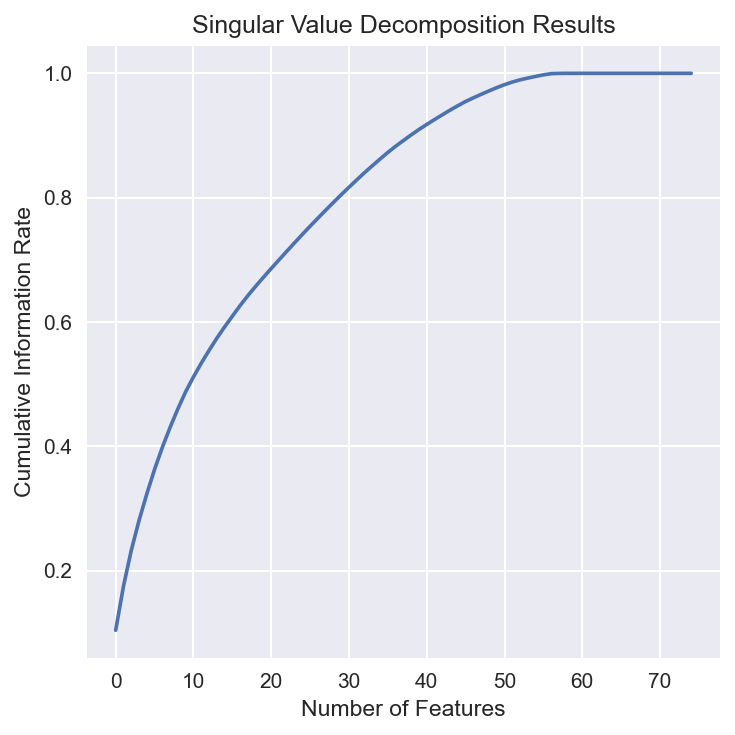

In [120]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(5, 5), dpi=150, tight_layout=True)
plt.plot(np.cumsum(s**2)/np.sum(s**2))
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Information Rate')
plt.title('Singular Value Decomposition Results')
plt.show()
fig.savefig('../results/svd.png', dpi=fig.dpi)

In [121]:
svd = TruncatedSVD(n_components=30)
svd.fit(scaled_X_train)

TruncatedSVD(algorithm='randomized', n_components=30, n_iter=5,
             random_state=None, tol=0.0)

In [122]:
best_features = [scaled_X_train.columns[col] for col in svd.components_[0].argsort()[: : -1][:30]]

In [123]:
best_features_explained_variance = svd.explained_variance_

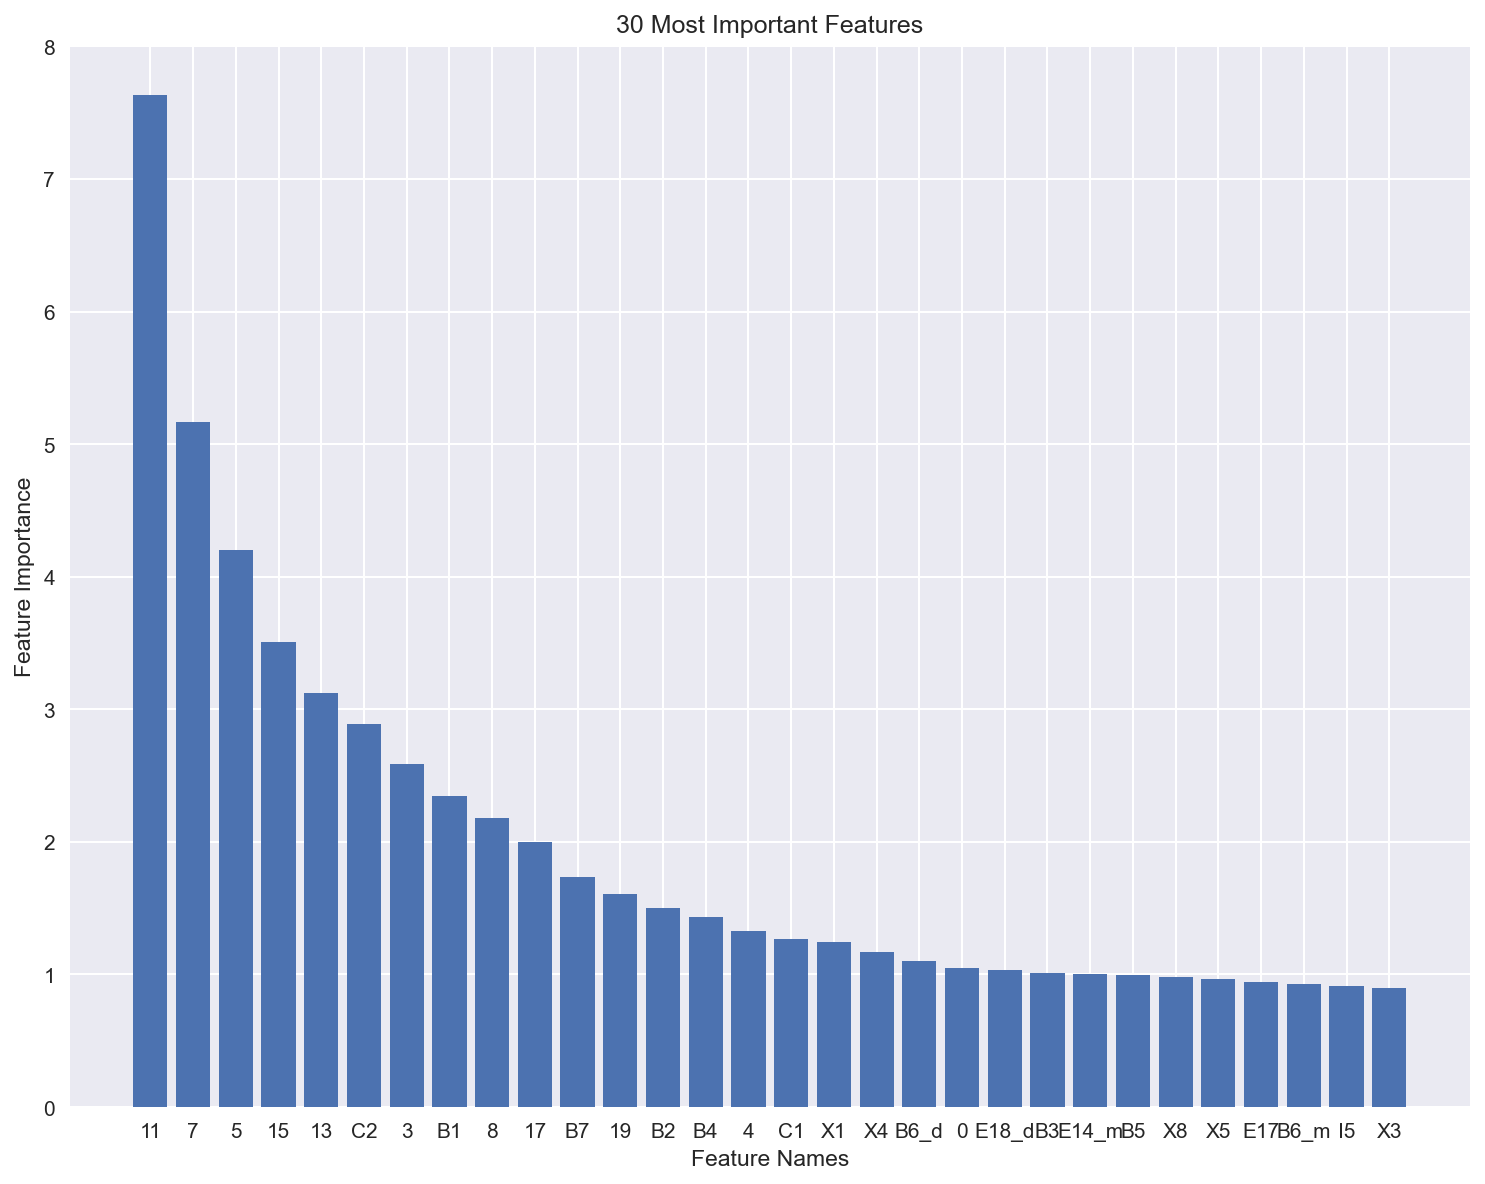

In [124]:
plt.style.use('seaborn')
fig = plt.figure(num=None, figsize=(10, 8), dpi=150, tight_layout=True)
plt.bar(best_features, height=best_features_explained_variance)
plt.xlabel('Feature Names')
plt.ylabel('Feature Importance')
plt.title('30 Most Important Features')
plt.show()
fig.savefig('../results/feature_importance.png', dpi=fig.dpi)

In [125]:
X_train_svd = X_train[best_features]
X_test_svd = X_test[best_features]
scaled_X_train_svd = scaled_X_train[best_features]
scaled_X_test_svd = scaled_X_test[best_features]

----

### Logistic Regression with Elastic Net (SVD)

In [126]:
l1_space = np.logspace(-1, 1, 10)
c_space = np.logspace(-2, 2, 5)
param_grid = {'C': c_space, 'l1_ratio': l1_space}

In [ ]:
logreg = LogisticRegression(solver='saga', penalty='elasticnet', max_iter=5000, verbose=0.1)
logreg_cv = GridSearchCV(logreg, param_grid, cv=5, scoring='roc_auc')

In [ ]:
logreg_cv.fit(scaled_X_train_svd, y_train.drop('cust_no', axis=1).ravel())

In [ ]:
best_param_logreg = logerg_cv.best_params_
validation_auc